<a href="https://colab.research.google.com/github/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler, MinMaxScaler

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Keras
from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, TimeDistributed, Dropout, Conv1D, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.optimizers import RMSprop
from keras.optimizers import Nadam

# Common imports
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

#Parameters
window_hours = 120 #24*7
forecast_hours = 24
traing_hours = 24*600
test_hours = 24*210

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function for plot
def plot_learning_curves(loss, val_loss, x_min_max=None, y_min_max=None):
    if x_min_max is None and y_min_max is None:
        x_min_max = [1,100]
        y_min_max = [0,70]
        
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([x_min_max[0], x_min_max[1], y_min_max[0], y_min_max[1]])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [3]:
#Read csv file
df = pd.read_csv('data_process_result/re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)
#df.drop(columns = [ 'level_0'], inplace = True)

df=df.dropna()

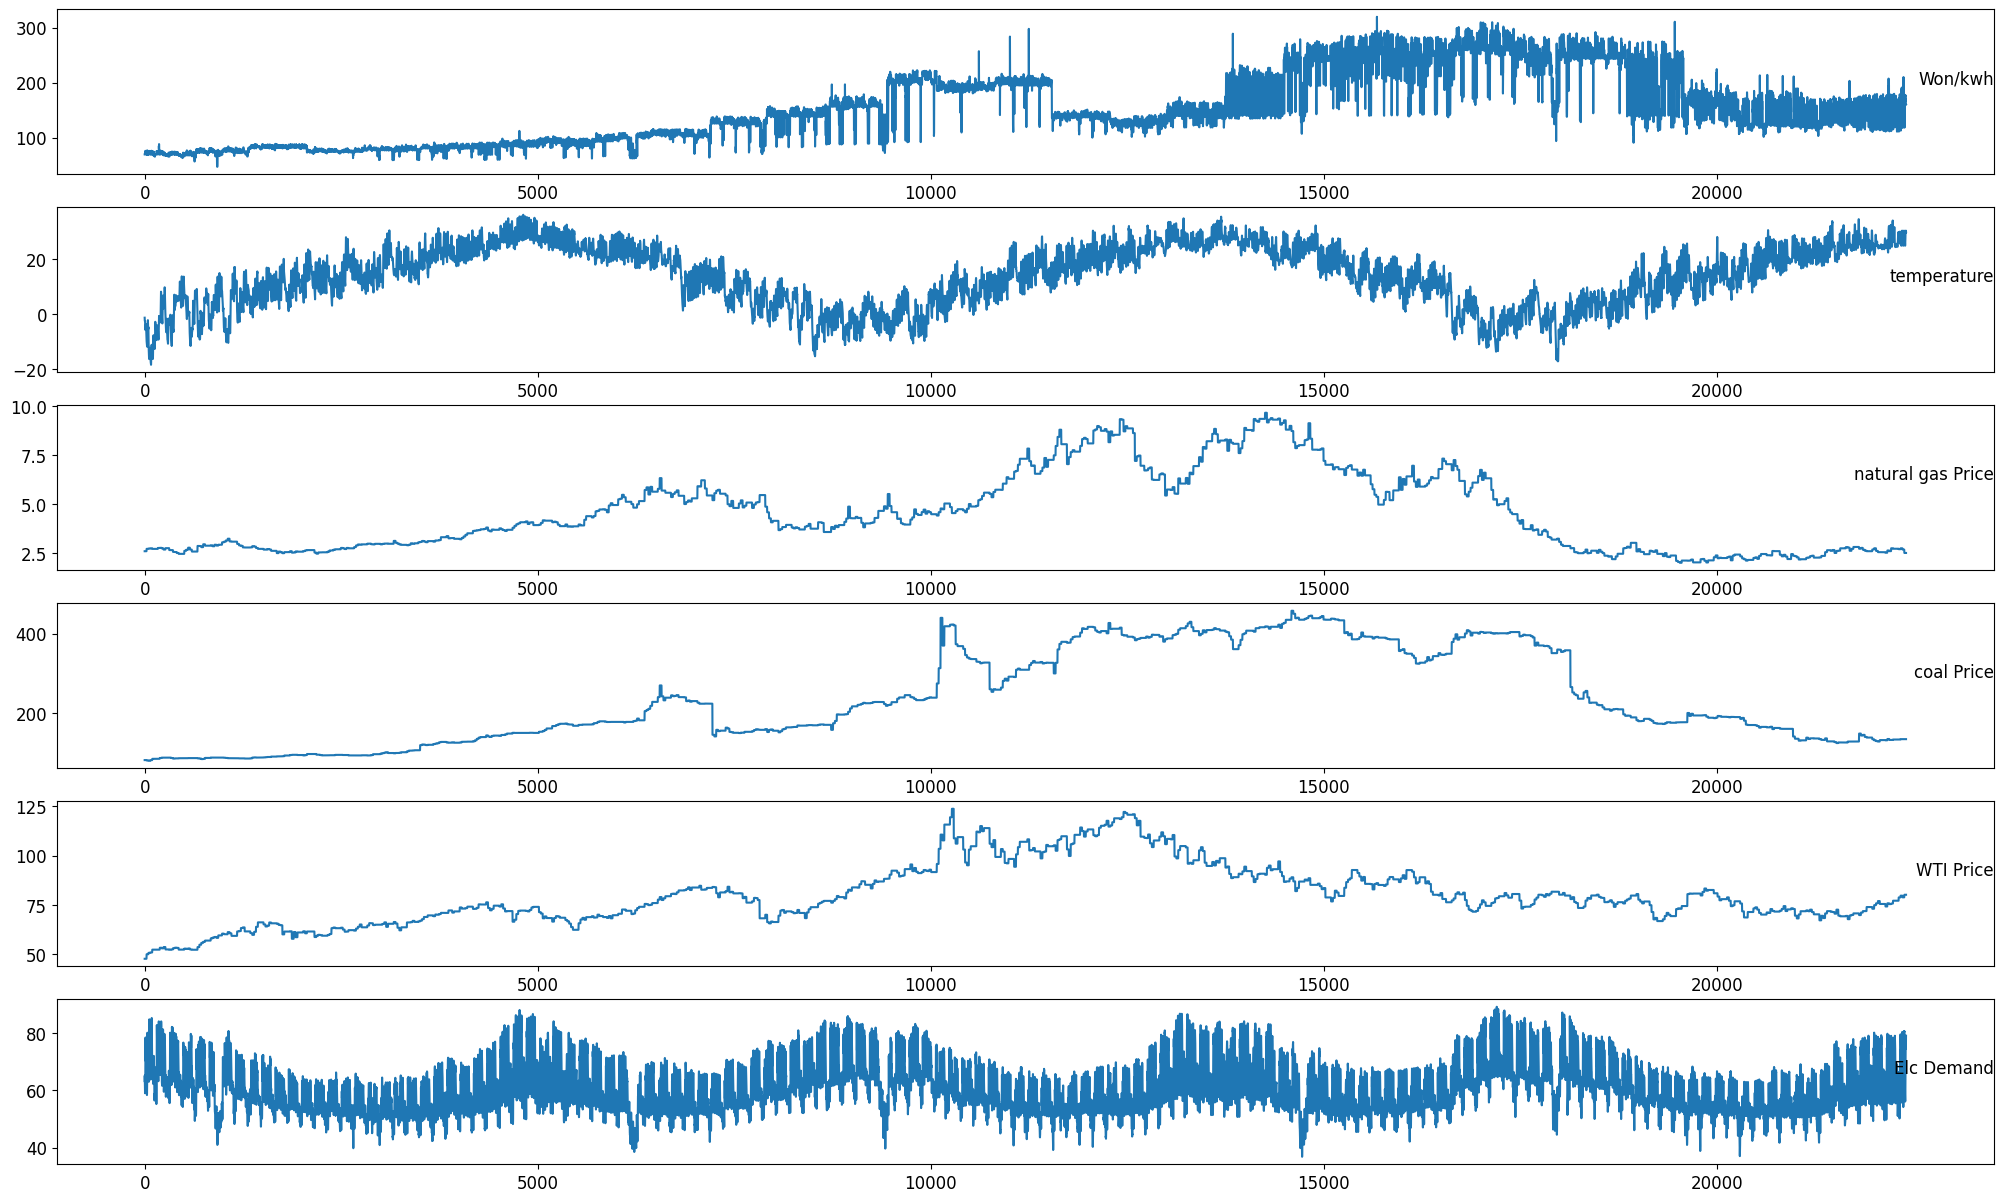

In [4]:
#Plot graph
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [7]:
# Normalize Datafram
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

168+24 인 192 시간으로 데이터를 편집한 것은 168시간으로 학습 시킨 뒤 24 시간을 예측하게 만들기 위함이라 예상됨

In [8]:
# 192hours time window (n_step+24)
series_reshaped =  np.array([data[i:i + (window_hours+forecast_hours)].copy() for i in range(len(data) - (window_hours+forecast_hours))])
print(series_reshaped.shape)


(22265, 144, 6)


In [9]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Train, valid, test data 만들기
X_train = series_reshaped[:traing_hours, :window_hours]
X_valid = series_reshaped[traing_hours:series_reshaped.shape[0]-test_hours, :window_hours]
X_test = series_reshaped[series_reshaped.shape[0]-test_hours:, :window_hours]
Y = np.empty((series_reshaped.shape[0], window_hours, forecast_hours))

for step_ahead in range(1, forecast_hours + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + window_hours, 0]
Y_train = Y[:traing_hours]
Y_valid = Y[traing_hours:series_reshaped.shape[0]-test_hours]
Y_test = Y[series_reshaped.shape[0]-test_hours:]
print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)


(14400, 120, 6) (2825, 120, 6) (5040, 120, 6) (14400, 120, 24) (2825, 120, 24) (5040, 120, 24)


#Note#
X_train.shape = (8760, 168,6) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 결과치를 (6) 6개의 요소에 대해 나타낸 것
Y_train.shape = (8760, 168,24) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 전력가격 결과를 (24) 24시간에 대해 나타낸 것

Deep Multivariate Recurrant Neural Network

In [10]:
#Training 

model6 = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    SimpleRNN(50, return_sequences=True),
    TimeDistributed(keras.layers.Dense(forecast_hours))
])
LR = 0.001
n_epochs = 30 #500

#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice


model6.compile(loss="mse", optimizer=RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False))
history = model6.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model6.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])

Epoch 1/30
450/450 [==============================] - 10s 19ms/step - loss: 0.0116 - val_loss: 0.0335
Epoch 2/30
450/450 [==============================] - 8s 19ms/step - loss: 0.0036 - val_loss: 0.0340
Epoch 3/30
450/450 [==============================] - 8s 19ms/step - loss: 0.0029 - val_loss: 0.0326
Epoch 4/30
450/450 [==============================] - 8s 18ms/step - loss: 0.0026 - val_loss: 0.0228
Epoch 5/30
450/450 [==============================] - 9s 19ms/step - loss: 0.0024 - val_loss: 0.0299
Epoch 6/30
450/450 [==============================] - 8s 19ms/step - loss: 0.0023 - val_loss: 0.0290
Epoch 7/30
450/450 [==============================] - 8s 18ms/step - loss: 0.0022 - val_loss: 0.0255
Epoch 8/30
450/450 [==============================] - 8s 19ms/step - loss: 0.0021 - val_loss: 0.0289
Epoch 9/30
450/450 [==============================] - 8s 18ms/step - loss: 0.0021 - val_loss: 0.0290
Epoch 10/30
450/450 [==============================] - 9s 20ms/step - loss: 0.0020 - val_l

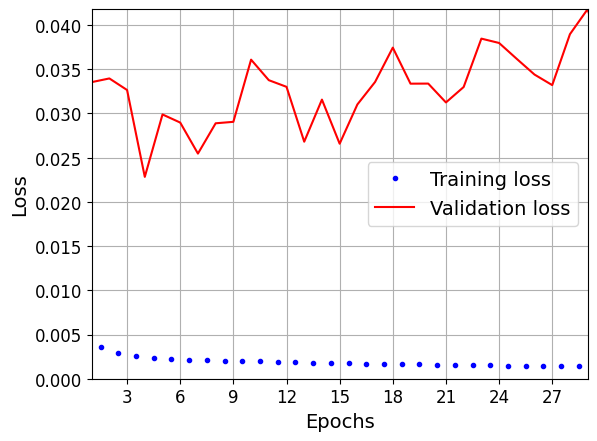

In [11]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

158/158 [==============================] - 1s 7ms/step


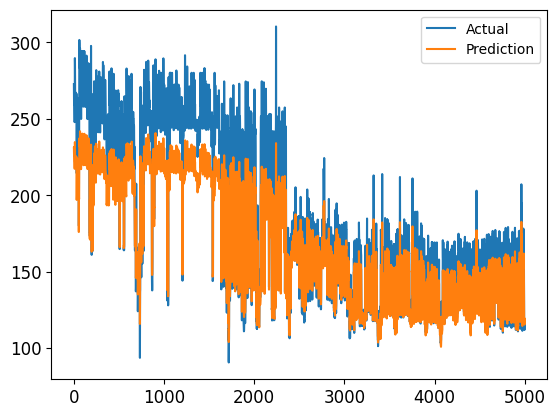

In [14]:
#Predict

Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['Won/kwh'].max() - df['Won/kwh'].min()) + df['Won/kwh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['Won/kwh'].max() - df['Won/kwh'].min()) + df['Won/kwh'].min())
actual['Actual'] = Y_act_inverse
actual['Prediction'] = Y_pred_inverse

actual.to_csv('model_result/SimpleRNNresults.csv') 

actual['Actual'][:5000].plot(legend=True)
actual['Prediction'][:5000].plot(legend=True)

actual1 = actual

Simple Long-Short Term Memory Model

In [74]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model8 = Sequential([
    LSTM(60, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    Dropout(0,2),
    LSTM(30, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
    
])

n_epochs = 80
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice

model8.compile(loss="MSLE", optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07))
history = model8.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model8.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])


Epoch 1/80
450/450 [==============================] - 31s 64ms/step - loss: 0.0181 - val_loss: 0.0243
Epoch 2/80
450/450 [==============================] - 28s 62ms/step - loss: 0.0017 - val_loss: 0.0082
Epoch 3/80
450/450 [==============================] - 28s 62ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 4/80
450/450 [==============================] - 28s 63ms/step - loss: 0.0012 - val_loss: 0.0096
Epoch 5/80
450/450 [==============================] - 28s 62ms/step - loss: 0.0010 - val_loss: 0.0092
Epoch 6/80
450/450 [==============================] - 28s 63ms/step - loss: 9.4764e-04 - val_loss: 0.0098
Epoch 7/80
450/450 [==============================] - 28s 62ms/step - loss: 8.7014e-04 - val_loss: 0.0091
Epoch 8/80
450/450 [==============================] - 28s 63ms/step - loss: 7.9794e-04 - val_loss: 0.0100
Epoch 9/80
450/450 [==============================] - 28s 62ms/step - loss: 7.4899e-04 - val_loss: 0.0101
Epoch 10/80
450/450 [==============================] - 28s 62ms/st

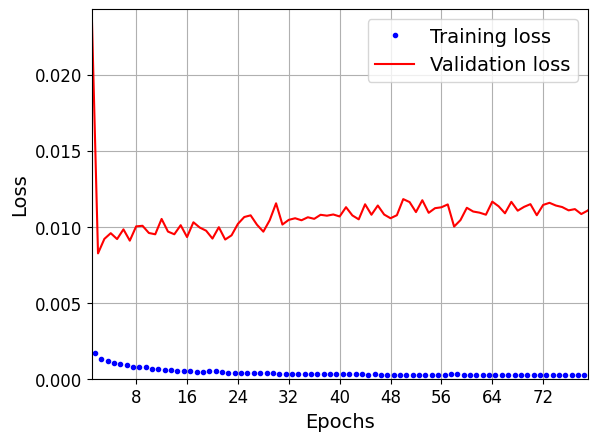

In [75]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

158/158 [==============================] - 4s 23ms/step


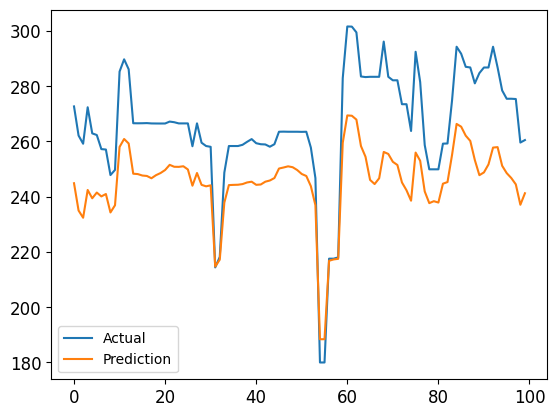

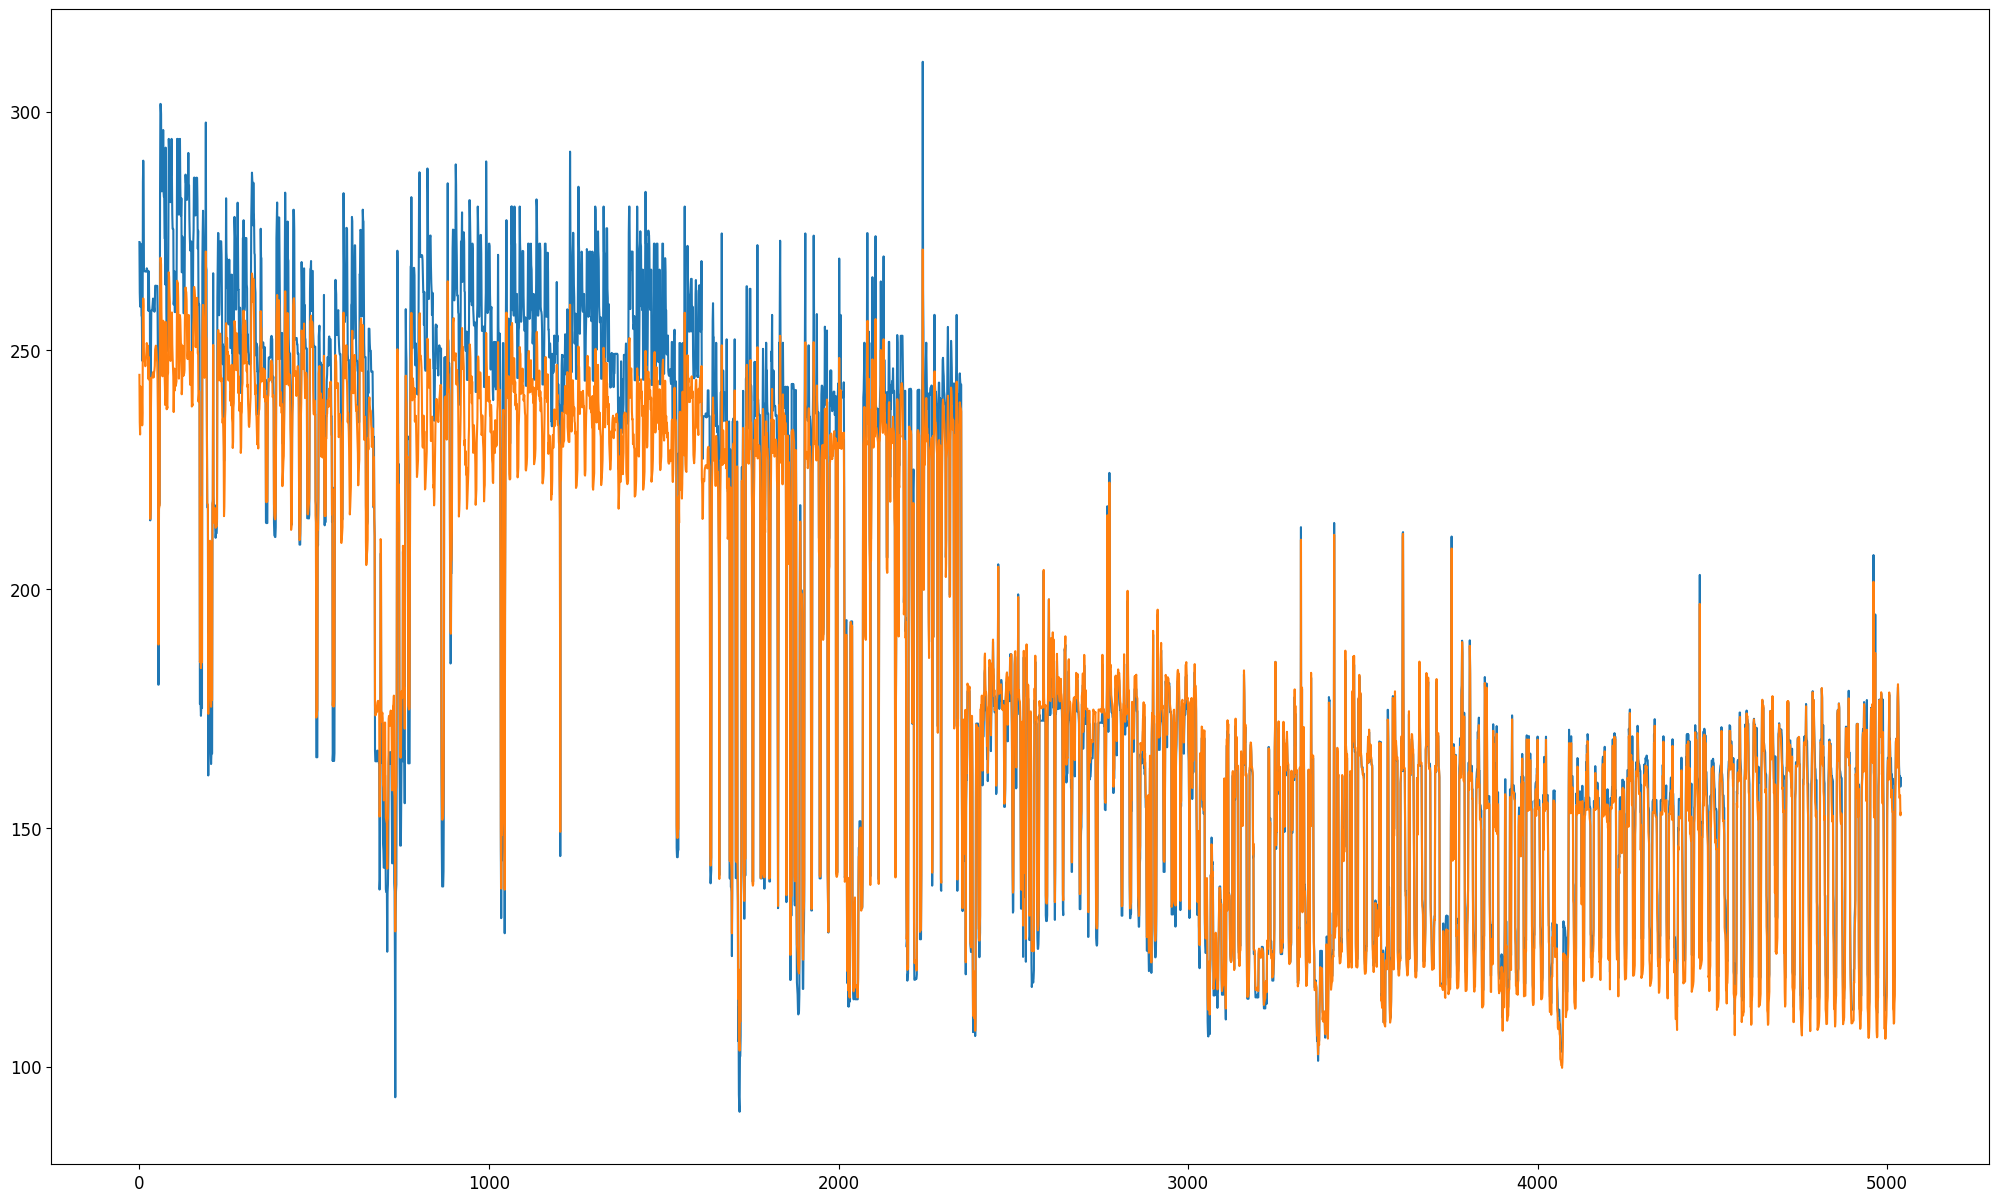

In [76]:
#Predict

Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    
actual = pd.DataFrame((X_test[:,0]))
#print(X_test)
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['Won/kwh'].max() - df['Won/kwh'].min()) + df['Won/kwh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['Won/kwh'].max() - df['Won/kwh'].min()) + df['Won/kwh'].min())
actual['Actual'] = Y_act_inverse
actual['Prediction'] = Y_pred_inverse

actual['Actual'][:100].plot(legend=True)
actual['Prediction'][:100].plot(legend=True)


# plot each column
plt.figure(figsize = (25, 15))
plt.plot(Y_act_inverse)
plt.plot(Y_pred_inverse)
	
plt.show()


actual.to_csv('model_result/LSTMresults.csv') 
actual2 = actual

Deep LSTM model

In [65]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model9 = Sequential([
    LSTM(80, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    Dropout(0,2),
    LSTM(50, return_sequences=True),
    Dropout(0,2),
    LSTM(30, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 100
model9.compile(loss="mse", optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07))
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history = model9.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks = [mc])
#history = model9.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks = [es,mc])

Epoch 1/100
450/450 [==============================] - 53s 110ms/step - loss: 0.0078 - val_loss: 0.0328
Epoch 2/100
450/450 [==============================] - 49s 110ms/step - loss: 0.0031 - val_loss: 0.0335
Epoch 3/100
450/450 [==============================] - 48s 106ms/step - loss: 0.0023 - val_loss: 0.0308
Epoch 4/100
450/450 [==============================] - 48s 107ms/step - loss: 0.0019 - val_loss: 0.0306
Epoch 5/100
450/450 [==============================] - 48s 106ms/step - loss: 0.0017 - val_loss: 0.0309
Epoch 6/100
450/450 [==============================] - 48s 106ms/step - loss: 0.0016 - val_loss: 0.0351
Epoch 7/100
450/450 [==============================] - 48s 107ms/step - loss: 0.0014 - val_loss: 0.0287
Epoch 8/100
450/450 [==============================] - 48s 106ms/step - loss: 0.0013 - val_loss: 0.0336
Epoch 9/100
450/450 [==============================] - 48s 107ms/step - loss: 0.0012 - val_loss: 0.0362
Epoch 10/100
450/450 [==============================] - 48s 108m

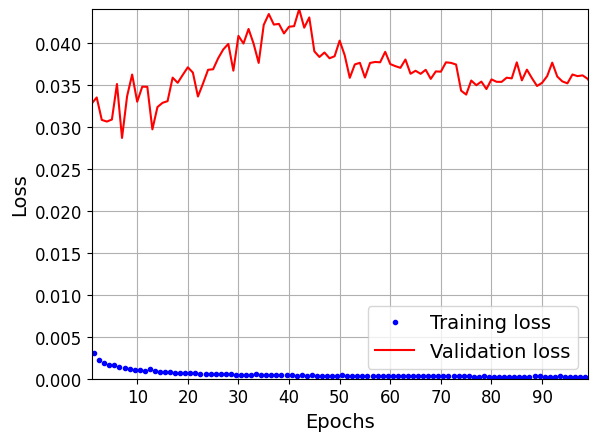

In [66]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

158/158 [==============================] - 7s 36ms/step


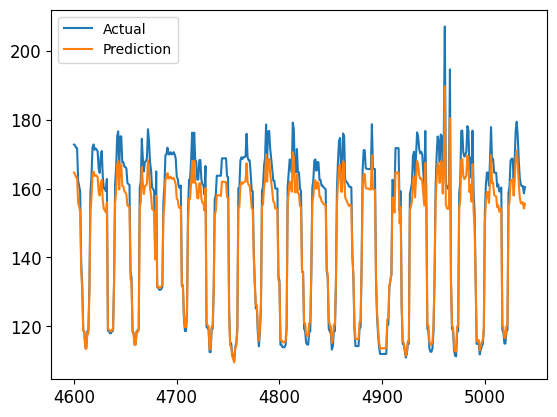

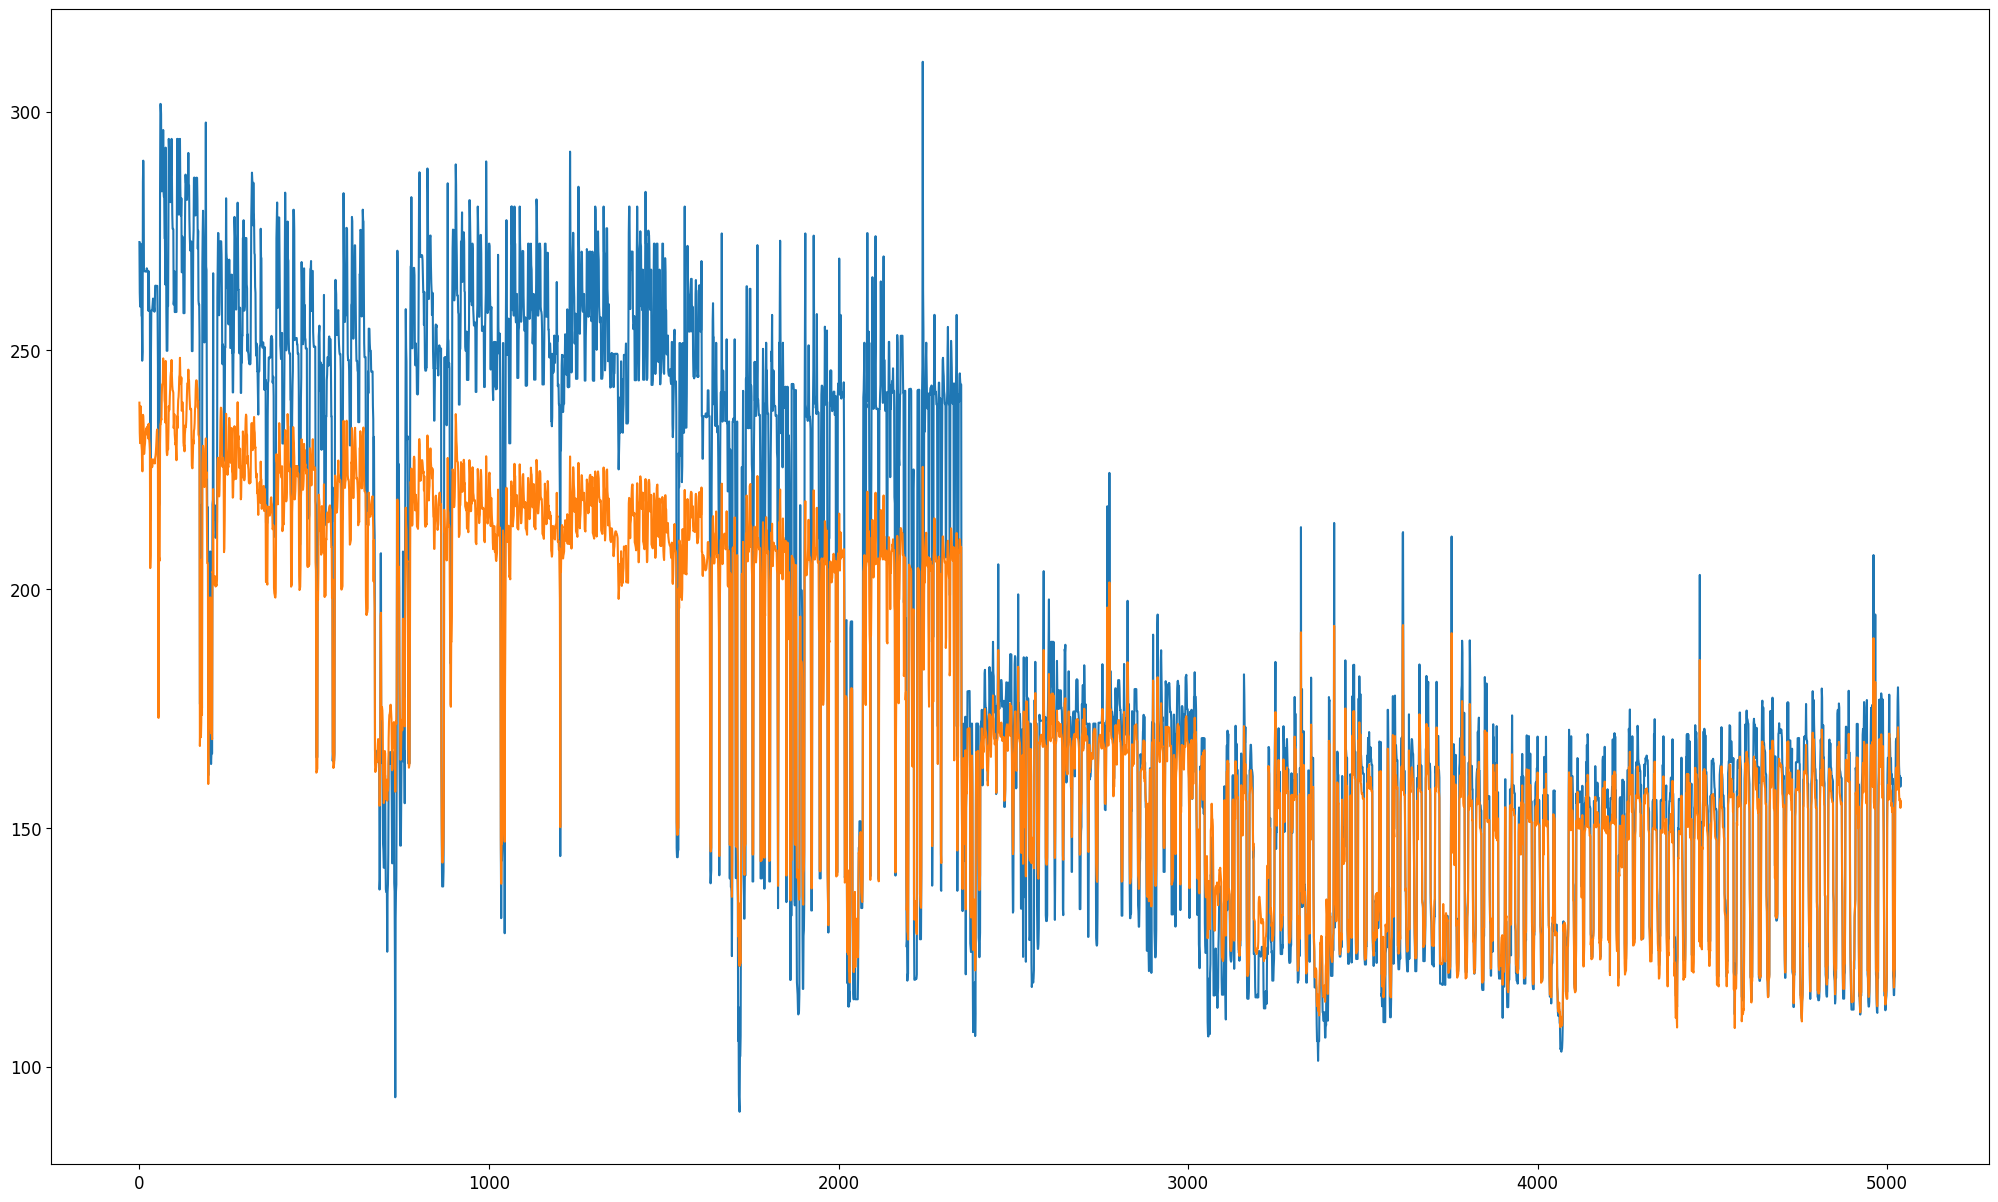

In [67]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['Won/kwh'].max() - df['Won/kwh'].min()) + df['Won/kwh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['Won/kwh'].max() - df['Won/kwh'].min()) + df['Won/kwh'].min())
actual['Actual'] = Y_act_inverse
actual['Prediction'] = Y_pred_inverse

actual['Actual'][4600:5040].plot(legend=True)
actual['Prediction'][4600:5040].plot(legend=True)

# plot each column
plt.figure(figsize = (25, 15))
plt.plot(Y_act_inverse)
plt.plot(Y_pred_inverse)
	
plt.show()


actual.to_csv('model_result/DeepLSTMresults.csv') 
actual2 = actual

Conv1D?

In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model10 = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, X_train.shape[2]]),
    GRU(60, return_sequences=True),
    GRU(40, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 500
model10.compile(loss="mape", optimizer="adam")
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [mc])
#history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es,mc])

Epoch 1/500
548/548 [==============================] - 30s 50ms/step - loss: 20.1465 - val_loss: 20.2326
Epoch 2/500
548/548 [==============================] - 27s 49ms/step - loss: 13.9747 - val_loss: 16.8128
Epoch 3/500
548/548 [==============================] - 27s 49ms/step - loss: 12.6040 - val_loss: 16.8075
Epoch 4/500
548/548 [==============================] - 27s 49ms/step - loss: 11.6067 - val_loss: 15.8368
Epoch 5/500
548/548 [==============================] - 27s 49ms/step - loss: 11.1065 - val_loss: 14.8159
Epoch 6/500
548/548 [==============================] - 27s 49ms/step - loss: 10.6634 - val_loss: 14.5553
Epoch 7/500
548/548 [==============================] - 27s 49ms/step - loss: 10.2541 - val_loss: 14.4075
Epoch 8/500
548/548 [==============================] - 27s 49ms/step - loss: 10.0435 - val_loss: 13.9985
Epoch 9/500
548/548 [==============================] - 27s 49ms/step - loss: 9.8779 - val_loss: 14.4603
Epoch 10/500
548/548 [==============================] - 

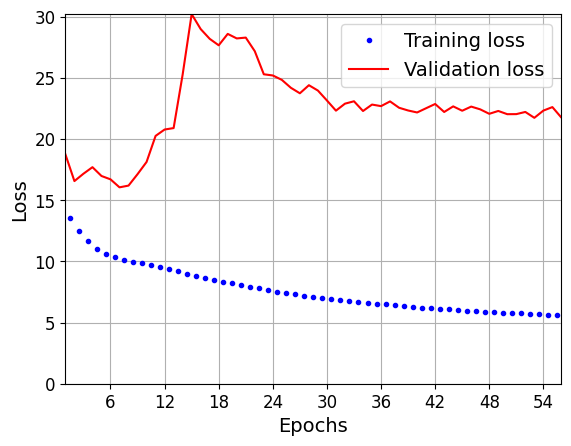

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 9s 32ms/step


<Axes: >

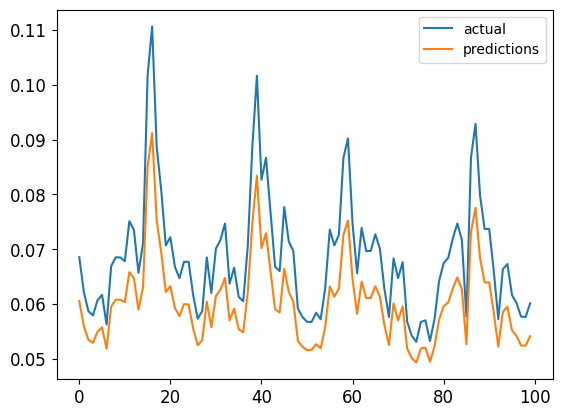

In [ ]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
actual['Actual'] = Y_pred_inverse
actual['Prediction'] = Y_act_inverse

actual['Actual'][:100].plot(legend=True)
actual['Prediction'][:100].plot(legend=True)


actual.to_csv('model_result/ConvIDresult.csv') 
actual4 = actual